In [1]:
import os
import json

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())


In [2]:
from openai import AzureOpenAI, OpenAI
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_4")
azure_openai_api_endpoint = os.getenv("AZURE_OPENAI_API_ENDPOINT_4")
deployment_name = os.getenv("AZURE_DEPLOYMENT_NAME_4")
openai_api_key = os.getenv('OPENAI_SIMPLON_API_KEY')
client = OpenAI(
    api_key=openai_api_key    
)
# client = AzureOpenAI(
#   api_key=azure_openai_api_key,
#   api_version="2024-02-01",
#   azure_endpoint=azure_openai_api_endpoint
# )

def get_completion(prompt, model='gpt-3.5-turbo'):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    return response.choices[0].message.content

## Assistants Components

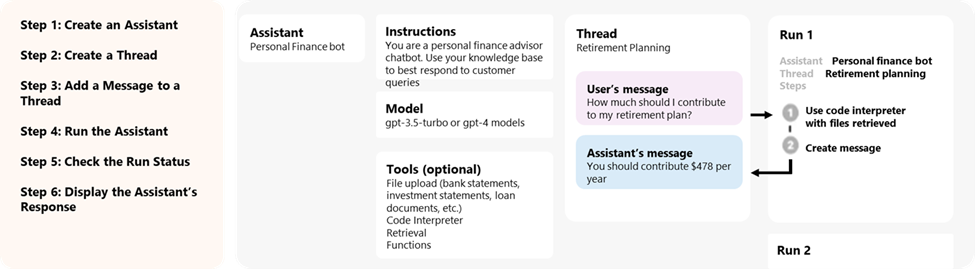


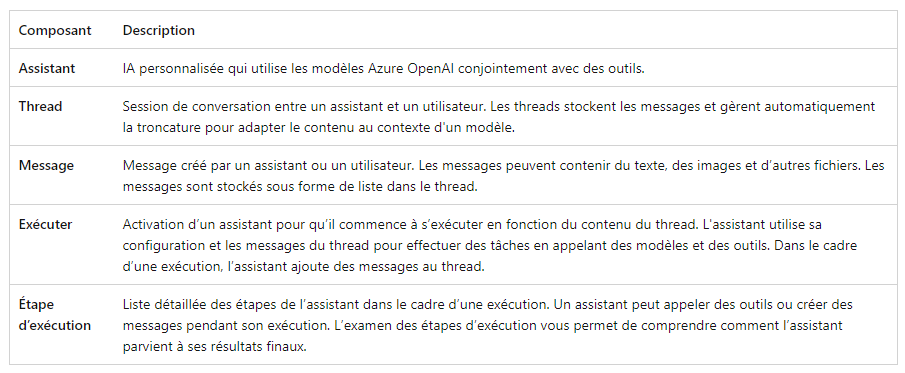

## List Assistants

In [7]:
my_assistants = client.beta.assistants.list(
    order="desc",
    limit="20",
)
print(my_assistants.data)


[Assistant(id='asst_8MmEkLXl2bhK00OcTHbuA0ig', created_at=1721833350, description=None, instructions='You are a weather bot. Use the provided functions to answer questions.', metadata={}, model='gpt-3.5-turbo', name=None, object='assistant', tools=[FunctionTool(function=FunctionDefinition(name='getCurrentWeather', description='Get the weather in location', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}, 'unit': {'type': 'string', 'enum': ['c', 'f']}}, 'required': ['location']}), type='function'), FunctionTool(function=FunctionDefinition(name='getNickname', description='Get the nickname of a city', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}}, 'required': ['location']}), type='function')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=None, file_search=None), top_p=1.0

## Create Assistant

### Example with code_interpreter as a tool

In [4]:
# Create an assistant
assistant = client.beta.assistants.create(
    name="Data Visualization",
    instructions=f"You are a helpful AI assistant who makes interesting visualizations based on data." 
    f"You have access to a sandboxed environment for writing and testing code."
    f"When you are asked to create a visualization you should follow these steps:"
    f"1. Write the code."
    f"2. Anytime you write new code display a preview of the code to show your work."
    f"3. Run the code to confirm that it runs."
    f"4. If the code is successful display the visualization."
    f"5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
    tools=[{"type": "code_interpreter"}],
    model='gpt-3.5-turbo' #You can replace this value with the deployment name for your model.
)


## Threads

### Create

In [5]:
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_hrNTsCubx4IyWFsYJlxbJy0k', created_at=1721820528, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


### Add message

In [6]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Create a visualization of a sinewave"
)

### List messages

In [7]:
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_uuXdqx5Lw4YMqaPN9vVMH6d4",
      "assistant_id": null,
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1721820528,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "status": null,
      "thread_id": "thread_hrNTsCubx4IyWFsYJlxbJy0k"
    }
  ],
  "object": "list",
  "first_id": "msg_uuXdqx5Lw4YMqaPN9vVMH6d4",
  "last_id": "msg_uuXdqx5Lw4YMqaPN9vVMH6d4",
  "has_more": false
}


### Create a run linked to a thread and an assistant

In [8]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

### Retrieve its status

In [9]:
# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

in_progress


### Continuously check for updates on run

[list of run status definitions](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant#run-status-definitions)

In [10]:
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
    status = run.status
    print(f'Status: {status}')
    clear_output(wait=True)

messages = client.beta.threads.messages.list(
  thread_id=thread.id
) 

print(f'Status: {status}')
print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
print(messages.model_dump_json(indent=2))

Status: completed
Elapsed time: 0 minutes 21 seconds
{
  "data": [
    {
      "id": "msg_4F6xzsEJ4HtPeDUGPA8ik8r0",
      "assistant_id": "asst_HpA4JXgRSoH7ny5VopI63ttG",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "image_file": {
            "file_id": "file-RLxpAQUNr0SXInzQE8K1eMzB"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is a simple plot of a sine wave. The x-axis represents the values from 0 to \\(2\\pi\\) and the y-axis represents \\(\\sin(x)\\). The graph shows the characteristic oscillating pattern of a sine wave. \n\nIf you need any modifications or additional details, please let me know!"
          },
          "type": "text"
        }
      ],
      "created_at": 1721820546,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "r

### Get the file_id

In [11]:
data = json.loads(messages.model_dump_json(indent=2))  # Load JSON data into a Python object
image_file_id = data['data'][0]['content'][0]['image_file']['file_id']

print(image_file_id)  # Outputs: assistant-1YGVTvNzc2JXajI5JU9F0HMD

file-RLxpAQUNr0SXInzQE8K1eMzB


### Retrieve the file with its id

In [12]:
content = client.files.content(image_file_id)

image= content.write_to_file("sinewave.png")

Ici la réponse était un fichier, mais la réponse peut évidemment être du texte, du code, des paramètres de fonction...

## Another example, with functions as tools

In [25]:
assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  name="weather_assistant",
  model='gpt-3.5-turbo', #Replace with model deployment name
  tools=[{
      "type": "function",
    "function": {
      "name": "getCurrentWeather",
      "description": "Get the weather in location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
          "unit": {"type": "string", "enum": ["c", "f"]}
        },
        "required": ["location"]
      }
    }
  }, {
    "type": "function",
    "function": {
      "name": "getNickname",
      "description": "Get the nickname of a city",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string", "description": "The city and state e.g. San Francisco, CA"},
        },
        "required": ["location"]
      }
    } 
  }]
)

In [26]:
assistant

Assistant(id='asst_6yBkYzubOX0cW9a0Yg0vWy9z', created_at=1721823201, description=None, instructions='You are a weather bot. Use the provided functions to answer questions.', metadata={}, model='gpt-3.5-turbo', name='weather_assistant', object='assistant', tools=[FunctionTool(function=FunctionDefinition(name='getCurrentWeather', description='Get the weather in location', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}, 'unit': {'type': 'string', 'enum': ['c', 'f']}}, 'required': ['location']}), type='function'), FunctionTool(function=FunctionDefinition(name='getNickname', description='Get the nickname of a city', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and state e.g. San Francisco, CA'}}, 'required': ['location']}), type='function')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=None, file_search=No

**Exercice** : Lancer cette assistant avec le prompt ci-dessous et récupérer les données renvoyées

- Qu'est-ce qui est renvoyé ?
- Quel est le status du run ?
- Quelles sont les informations renvoyés par l'assistant ?
- Que peut-on en faire ensuite ?
- Optionnel : Faites la suite !

Aide : https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant-functions?tabs=python 

Prompt : `Get the weather in LA`

(Vous pouvez toujours en essayer d'autres après)

In [21]:
thread = client.beta.threads.create()
print(thread)

# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Get the weather in LA"
)


Thread(id='thread_jjzl5KFwcWnTLfrmAW0ULpso', created_at=1721912368, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


In [22]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id="asst_6yBkYzubOX0cW9a0Yg0vWy9z" # assistant.id
)

In [19]:
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
    status = run.status
    print(f'Status: {status}')
    clear_output(wait=True)

messages = client.beta.threads.messages.list(
  thread_id=thread.id
) 

print(f'Status: {status}')
print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
print(messages.model_dump_json(indent=2))

Elapsed time: 0 minutes 47 seconds
Status: requires_action


: 

In [23]:
run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)

In [24]:
print(run.model_dump_json(indent=2))

{
  "id": "run_NJUANF9Je9tMtcQ9NQAd7z3y",
  "assistant_id": "asst_6yBkYzubOX0cW9a0Yg0vWy9z",
  "cancelled_at": null,
  "completed_at": null,
  "created_at": 1721912369,
  "expires_at": 1721912969,
  "failed_at": null,
  "incomplete_details": null,
  "instructions": "You are a weather bot. Use the provided functions to answer questions.",
  "last_error": null,
  "max_completion_tokens": null,
  "max_prompt_tokens": null,
  "metadata": {},
  "model": "gpt-3.5-turbo",
  "object": "thread.run",
  "required_action": {
    "submit_tool_outputs": {
      "tool_calls": [
        {
          "id": "call_JHbPlQKiJTYr2t3ZvTPay90E",
          "function": {
            "arguments": "{\"location\":\"Los Angeles\",\"unit\":\"c\"}",
            "name": "getCurrentWeather"
          },
          "type": "function"
        }
      ]
    },
    "type": "submit_tool_outputs"
  },
  "response_format": "auto",
  "started_at": 1721912370,
  "status": "requires_action",
  "thread_id": "thread_jjzl5KFwcWnTLfrm

In [12]:
run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
status = run.status
print(status)

requires_action


In [25]:
import requests

weather_api_key = os.getenv("WEATHERAPI_API_KEY")

def getCurrentWeather(**args):
  try:
    location = args.get('location')
    unit = args.get('unit', 'c')

    url = 'https://api.weatherapi.com/v1/current.json'
    params = {
        'q': location,
        'key': weather_api_key
    }
    headers = {
        'accept': 'application/json'
    }
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()
      current_data = data.get('current')

      return json.dumps(current_data)
    else:
        return "Failed to retrieve data: {response.status_code}"
        # raise Exception(f"Failed to retrieve data: {response.status_code}")
  except Exception as e:
    return {'error': str(e)}


In [ ]:
arguments = json.loads('{\"location\":\"Los Angeles\",\"unit\":\"f\"}')
weather = getCurrentWeather(**arguments)
print(weather)

In [16]:
globals()['getCurrentWeather']()

<function __main__.getCurrentWeather(**args)>

In [26]:
def submit_function_outputs(run, thread):
  if run.required_action.submit_tool_outputs.tool_calls:
    tool_calls = run.required_action.submit_tool_outputs.tool_calls
    
    tool_outputs = []
    for i, tool_call in enumerate(tool_calls):
      function_name = tool_call.function.name
      arguments = json.loads(tool_call.function.arguments)
      
      response = globals()[function_name](**arguments)

      tool_outputs.append({
        "tool_call_id": tool_call.id,
        "output": response # doit contenir la réponse de votre fonction python qui prend en entrée les arguments renvoyés par le run
      })

    run = client.beta.threads.runs.submit_tool_outputs(
      thread_id=thread.id,
      run_id=run.id,
      tool_outputs=tool_outputs
    )
  return None

In [27]:
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
  
  run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
  print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
  status = run.status
  print(f'Status: {status}')

  if run.status == "requires_action":
    print('executing tools...')
    submit_function_outputs(run, thread)

  clear_output(wait=True)

  time.sleep(3)

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(f'Status: {status}')
print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
print(messages.model_dump_json(indent=2))

Status: completed
Elapsed time: 0 minutes 7 seconds
{
  "data": [
    {
      "id": "msg_2votuL7e6HxGViUD6XfgWNhk",
      "assistant_id": "asst_6yBkYzubOX0cW9a0Yg0vWy9z",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "The current weather in Los Angeles is as follows:\n- Temperature: 23.9°C (75.0°F)\n- Condition: Clear\n- Wind: 4.0 km/h from WSW\n- Pressure: 1016.0 mb\n- Humidity: 59%\n- Feels like: 25.3°C (77.6°F)"
          },
          "type": "text"
        }
      ],
      "created_at": 1721912416,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_NJUANF9Je9tMtcQ9NQAd7z3y",
      "status": null,
      "thread_id": "thread_jjzl5KFwcWnTLfrmAW0ULpso"
    },
    {
      "id": "msg_29z9Dceef4pYrFspd6Zf8qYc",
      "assistant_id": null,
      "attachments": [],
     

## Optionnel : A vous de jouer !

Implémentez l'Assistant de votre choix qui appele une API ensuite.

Pour des idées, voici un ChatGPT conçu pour vous aider à trouver des APIs de votre choix : https://chatgpt.com/g/g-LrNKhqZfA-there-s-an-api-for-that-the-1-api-finder 

**Vous pouvez le faire en code (avec OpenAI et pas Azure), ou sur Azure AI Studio ou Azure OpenAI Studio**